In [ ]:
#Importamos librerías
import torch
from torch import nn
import nltk
from nltk.corpus import reuters
from nltk.corpus import stopwords
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import string
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Descargamos corpus y herramientas de procesamiento
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Montamos nuestro drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copiamos código visto en clase necesario para que todo funcione correctamente
def preprocess_corpus(corpus: list[str]) -> list[str]:
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

def get_words_freqs(corpus: list[list[str]]):
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

def get_words_indexes(words_freqs: dict) -> dict:
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        if words_freqs[word] == 1:
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx
    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

#Realizamos una pequeña configuración para que el load funcionara bien con el dispositivo actual
def get_model(path: str, device='cpu') -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path,map_location=device))
    model_loaded.eval()
    return model_loaded

#Creamos una función para obtener las n palabras más similares a una palabra dada mediante la similitud coseno
def topn_sim_words(word,word_embeddings, n=10):
    """Obtiene las n palabras más similares a una dada mediante la similitud coseno"""
    similitudes={}
    #print(similitudes)
    if word in word_embeddings:
     embedding_word= word_embeddings[word]
     #print(embedding_word)
     for words,embedding in word_embeddings.items():
        if words==word:
            continue
        words_embedding= embedding

        similitudes[words]=cosine_similarity(embedding_word.reshape(1,-1),words_embedding.reshape(1,-1))[0][0]
     #print(similitudes)
     similitudes_ord=sorted(similitudes.items(),key=lambda x:x[1],reverse=True)
     return similitudes_ord[:n]
    else:
     return None

Obtenemos los embeddings dados por el modelo

In [ ]:
#Parámetros vistos en clase
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
H = 100
UNK_LABEL = "<UNK>"

# Cargamos datos y creamos vocabulario
corpus = preprocess_corpus(reuters.sents())
words_freqs = get_words_freqs(corpus)
words_indexes, index_to_word = get_words_indexes(words_freqs)
V = len(words_indexes)

# Cargamos modelo entrenado en clase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Ciencia de Datos/8.Octavo Semestre/Temas selectos de PLN/Pŕacticas/Práctica 4/Models/model_cuda_context_2_epoch_9.dat"
model= get_model(model_path,device)


# Extraemos embeddings
embeddings = model.embeddings.weight.data

# Creamos diccionario de embeddings
word_embeddings = {word: embeddings[idx].numpy()
                  for word, idx in words_indexes.items()
                  if idx < embeddings.shape[0]}

# Probamos nuestro método con la palabra the
print("Embedding para 'the':", word_embeddings.get('the', 'Palabra no encontrada'))
print("Dimensión del embedding:", embeddings.shape[1])

Embedding para 'the': [ 0.16482496 -0.6663401   0.29231626 -0.7992205  -0.50945306  0.08567516
 -0.00888291  0.18690939  0.5244595   1.0506742  -0.22363046  0.9366742
  0.4547838   0.49217173 -1.2761682  -0.7620734   0.8435289   0.61999846
 -0.81782866  0.7336605   0.07490944  0.8156883   0.2605004   0.30564642
  0.7071731   0.36908957 -0.4233488  -0.09735711 -0.33768725  0.7154012
 -0.1325352   0.39956513 -0.44338566 -0.22866488  1.3218973   0.66806775
 -1.2800189  -0.00640732  0.8172127   1.3891668  -0.550817   -1.0404494
 -0.06021678 -0.36652648  0.21733128 -1.1902025   0.5557314   0.72797525
 -0.4668451   0.39451993  0.19276792 -0.23590058  0.53990054 -0.08556841
  0.5465661  -1.4645723   0.09432201  0.7676544   0.0374487  -0.22570165
 -0.49479768 -0.23371647  0.301534   -0.31184122 -0.5660863  -0.25279295
  0.03591231 -0.09920677  0.00670439 -0.23115861 -1.068803    0.21160103
  0.61557007 -0.22124842 -0.42767587 -0.5178698   0.49805003  0.32364145
 -0.653208    0.41065812 -0.6410

Visualizamos los embeddings en 2D mediante reducción de dimensionalidad de las palabras más frecuentes excluyendo stopwords, tokens especiales y signos de puntuación.

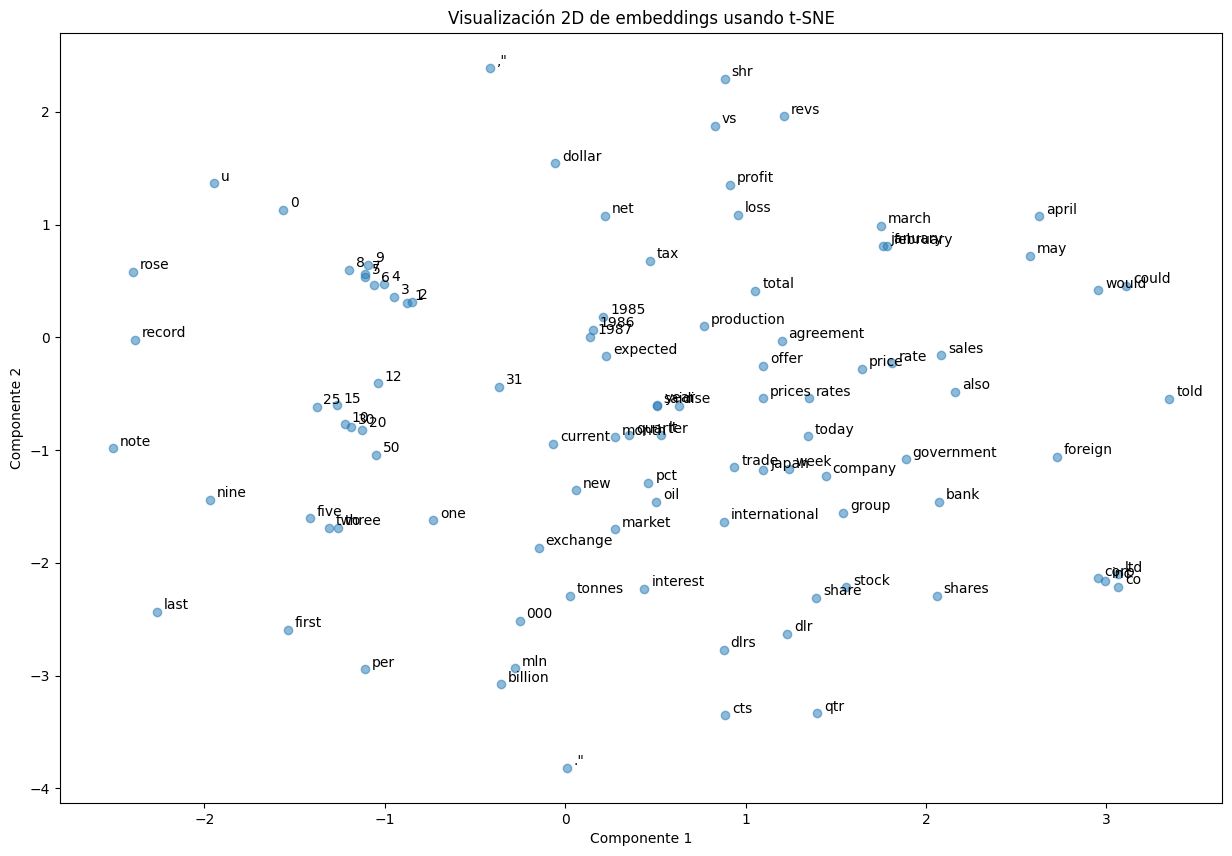

In [ ]:
#Obtener las stopwords
stop_words = set(stopwords.words('english'))

# Obtuvimos las 50 palabras más frecuentes (excluyendo stopwords, tokens especiales y símbolos de puntuación)
top_words = sorted([(freq, word) for word, freq in words_freqs.items()
                   if word not in stop_words
                   and word not in ["<BOS>", "<EOS>", "<UNK>"] and word not in string.punctuation], reverse=True)[:100]

# Obtuvimos los embeddings correspondientes
selected_words = [word for _, word in top_words]
selected_embeddings = [embeddings[words_indexes[word]].numpy() for word in selected_words]

# Redujimos dimensionalidad con t-SNE para una mejor visualización
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(np.array(selected_embeddings))

# Configuramos el gráfico
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Añadimos etiquetas
for i, word in enumerate(selected_words):
    plt.annotate(word,
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 textcoords="offset points",
                 xytext=(5,2),
                 ha='left')

plt.title("Visualización 2D de embeddings usando t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

Lo que podemos observar es que si bien es cierto algunas palabras están cercanas (como los años, meses o números) en general tenemos una alta dispersión, lo cual no es buena señal pues deberíamos de ver algunas agrupaciones en ciertos temas en común.

Obtenemos las 10 palabras más cercanas semánticamente mediante similitud coseno de algunas palabras de prueba.

In [89]:
#Obtener similitud de diferentes palabras
words_sim=topn_sim_words('march',word_embeddings)
print(f'Palabras cercanas a March: {words_sim}')
words_sim=topn_sim_words('microsoft', word_embeddings)
print(f'Palabras cercanas a Microsoft: {words_sim}')
words_sim=topn_sim_words('government', word_embeddings)
print(f'Palabras cercanas a Government: {words_sim}')
words_sim=topn_sim_words('mexico', word_embeddings)
print(f'Palabras cercanas a Mexico: {words_sim}')
words_sim=topn_sim_words('car', word_embeddings)
print(f'Palabras cercanas a Car: {words_sim}')

Palabras cercanas a March: [('june', np.float32(0.36931756)), ('december', np.float32(0.36336237)), ('august', np.float32(0.34741575)), ('nov', np.float32(0.34452724)), ('oct', np.float32(0.30332932)), ('january', np.float32(0.29935455)), ('reopen', np.float32(0.293341)), ('july', np.float32(0.29278702)), ('marcxh', np.float32(0.29242665)), ('es', np.float32(0.28445247))]
Palabras cercanas a Microsoft: [('itt', np.float32(0.29703146)), ('091', np.float32(0.28064817)), ('mcm', np.float32(0.27359256)), ('conditioning', np.float32(0.2703712)), ('argosystems', np.float32(0.26492342)), ('479', np.float32(0.2635857)), ('acrt', np.float32(0.2570569)), ('microdyne', np.float32(0.25339502)), ('ert', np.float32(0.24764591)), ('rtrs', np.float32(0.24725568))]
Palabras cercanas a Government: [('bullish', np.float32(0.29743764)), ('reassurance', np.float32(0.26078013)), ('interagency', np.float32(0.25258252)), ('resumes', np.float32(0.24922353)), ('ministry', np.float32(0.24492675)), ('aero', np.fl

Al obtener palabras semánticamente similares mediante la distancia coseno, podemos observar que no fuimos capaces de captar relaciones semánticas, pues en la mayoría de los casos no tiene mucho sentido las palabras con mayor similitud coseno. Además, podemos observar que los valores de la similitud no son tan altos, lo que nos habla de que si bien es cierto que son las palabras más cercanas no están tan cercanas como quisieramos. Por útlimo, atribuímos esto al corpus con el que fue entrenado nuestro modelo. Investigando un poco notamos que nuestro corpus (Reusters) está compuesto por noticias financieras y de otro tipo, lo que lo hace no tan diverso como otros corpus más amplios (como Wikipedia), además, el lenguaje suele ser específico del dominio periodístico y financiero, lo que podrías limitar la generalización de las relaciones semánticas. Normalmente, Reuters se utiliza para realizar clasificación de texto, pero no es común usarlo para capturar relaciones semánticas por todo lo comentado anteriormente. De esta manera, notamos la gran importancia de la correcta elección del corpus de entrenamiento para que nuestro modelo lleva a cabo ciertas tareas de manera eficiente.

Nota: Se intentó utilizar los modelos proporcionados mediante drive. Sin embargo, al tener un vocabulario menor no fuimos capaces de poder utilizarlos.